In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
#import seaborn as sns
import theano.tensor as tt
from sklearn.model_selection import train_test_split

#sns.set(style='white', palette='deep', color_codes=True)

%matplotlib inline

block0 = pd.read_csv('/gpfs/projects/UITS/IUNI/IMAGENE/Phom_output/subFeaturesAll.csv')
data = block0[['AGE','EDU','GENDER','DX']]
mask = np.isfinite(data['AGE'])
data = data[mask]
#data.DX.unique()
train, test = train_test_split(data, test_size=0.2, stratify=data.DX)
maskT = data.index.isin(train.index)
len(maskT)

155

In [17]:
!pip install pymc3==3.7
#!pip freeze

You should consider upgrading via the 'pip install --upgrade pip' command.


In [70]:
#!pip freeze
#!source activate root
import pkg_resources
#pkg_resources.require("pymc3==3.7")
import pymc3 as pm
pkg_resources.get_distribution("pymc3").version

'3.6'

In [71]:
K1 = pd.read_csv('/gpfs/projects/UITS/IUNI/IMAGENE/workingdir/yan30/thickPH0thinKernelPD.tsv', header=None, sep='\t').values
K1 = K1[mask,:]
K1 = K1[:,mask]
K1Tr = K1[maskT,:]
K1Tr = K1Tr[:,maskT]
K2 = pd.read_csv('/gpfs/projects/UITS/IUNI/IMAGENE/workingdir/yan30/thickPH1thinKernelPD.tsv', header=None, sep='\t').values
K2 = K2[mask,:]
K2 = K2[:,mask]
K2Tr = K2[maskT,:]
K2Tr = K2Tr[:,maskT]
n = len(K2Tr)
#K2Tr = K2Tr + 1e4 * np.eye(n)
np.linalg.cholesky(K2Tr)
#K1Tr = K1Tr + 1e4 * np.eye(n)
np.linalg.cholesky(K1Tr)

array([[ 3.00434200e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.77391368e+01,  3.51964690e+01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.96012993e+01,  4.41392573e+01,  1.96437016e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.51003100e+01,  7.05210168e+00, -1.87449845e+00, ...,
         1.15370906e-01,  0.00000000e+00,  0.00000000e+00],
       [ 3.67068138e+01,  5.37029186e+00, -2.54771992e+00, ...,
        -1.15518212e-02,  9.81548745e-02,  0.00000000e+00],
       [ 3.71795670e+01,  7.88086674e+00, -3.29412301e+00, ...,
         7.23287917e-04,  1.01519635e-03,  5.55821623e-02]])

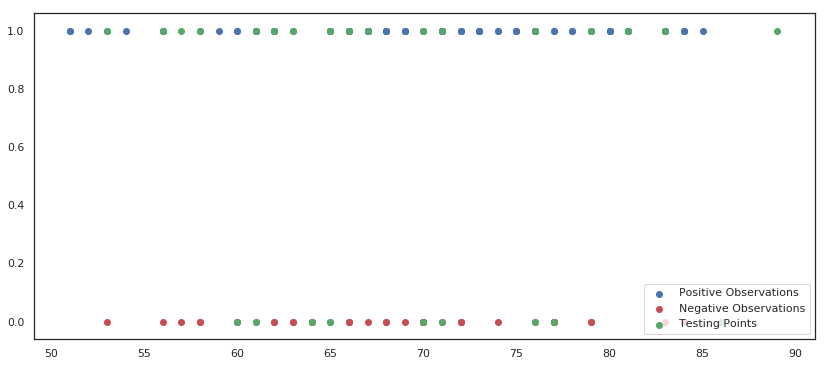

In [72]:
# Number of training points
n = len(train)
X0 = train[['AGE']].values

# Number of testing points
m = len(test)
X = test[['AGE']].values

n = len(train)
Y0 = train[['DX']].values
Y = test[['DX']].values
# Separate data into positive and negative classes
Y[Y == 'MCI'] = 1
Y[Y == 'NC'] = 0
Y0[Y0 == 'MCI'] = 1
Y0[Y0 == 'NC'] = 0

fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, np.ma.masked_where(Y0 == 0, Y0), color='b', label='Positive Observations');
ax.scatter(X0, np.ma.masked_where(Y0 == 1, Y0), color='r', label='Negative Observations');
ax.scatter(X, Y, color='g', label='Testing Points');
ax.legend(loc='lower right');
#ax.set_xlim(-0.1, 3.1);
#ax.set_ylim(-0.2, 1.2);

In [80]:
with pm.Model() as model:
    # Again, f_sample is just a dummy variable
    f_sample = pm.Flat('f_sample', shape=n)
    f_transform = pm.invlogit(f_sample)

    # Binomial likelihood
    
    y = pm.Binomial('y', observed=Y0, n=np.ones(n), p=f_transform, shape=n)

    # Interpolate function values using noiseless covariance matrix
    # Covariance kernel parameters
    l = 0.3 #= pm.Gamma("l", alpha=2, beta=2)
    # informative, positive normal prior on the period
    eta = pm.HalfNormal("eta",tau=1/5)
    eta2 = pm.HalfNormal("eta2",tau=1/5)
    cov = pm.gp.cov.ExpQuad(1, l) + eta**2 *K1Tr + eta2**2 *K2Tr
    cov0 = pm.gp.cov.ExpQuad(1, l)
    #noise = 0.1

    #cov = f_scale * pm.gp.cov.ExpQuad(1, lengthscale)
    K = cov(X0)
    K_s = cov0(X0, X)
    #K_noise = K + noise * np.eye(n)

    # Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
    K_stable = K + 1e-12 * np.eye(n)

    L = tt.slinalg.cholesky(K_stable)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_transform))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace8 = pm.sample(40000, tuning = 5000, target_accept=0.8, progressbar=True, step=[ess_step], chains = 4, cores = 16)

Multiprocess sampling (4 chains in 16 jobs)
CompoundStep
>EllipticalSlice: [f_sample]
>NUTS: [eta2, eta]
Sampling 4 chains: 100%|██████████| 162000/162000 [7:58:20<00:00,  4.31draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8888670544436135, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [10]:
with pm.Model() as model:
    # covariance function
    l = 0.3 #pm.Gamma("l", alpha=2, beta=2)
    # informative, positive normal prior on the period
    eta = pm.HalfNormal("eta",tau=1/5)
    eta2 = pm.HalfNormal("eta2",tau=1/5)
    cov = pm.gp.cov.ExpQuad(1, l) + eta**2 *K1Tr + eta2**2 *K2Tr
    
    gp = pm.gp.Latent(cov_func=cov)

    # make gp prior
    f = gp.prior("f", X=X0)

    # logit link and Bernoulli likelihood
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=Y0)

    trace2 = pm.sample(20000, tune = 8000, target_accept=0.99, progressbar=True, chains = 4, cores = 10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [f_rotated_, eta2, eta]
Sampling 4 chains:   0%|          | 0/112000 [00:00<?, ?draws/s]


RuntimeError: Chain 0 failed.

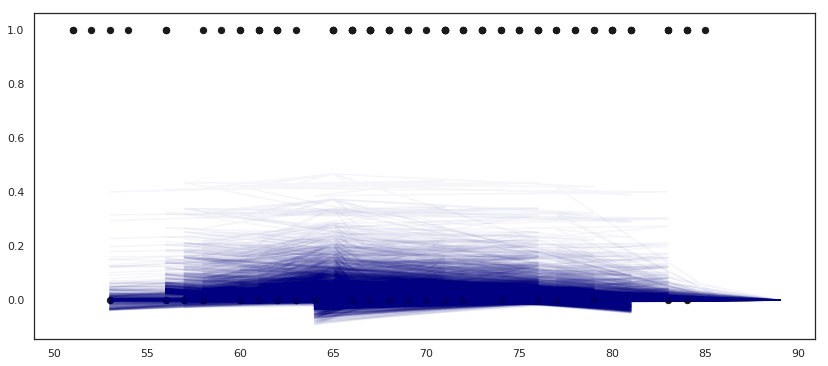

In [76]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace99['f_pred'][idx],  alpha=0.04, color='navy')
ax.scatter(X0, Y0, s=40, color='k');
#ax.set_xlim(0, 3);
#ax.set_ylim(-0.1, 1.1);

In [77]:
pm.summary(trace99, varnames=['eta', 'eta2'])
#pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta,1.796139,1.350725,0.005134,0.000009,4.396285,65295.617792,1.000028
eta2,1.783254,1.349367,0.004397,0.000123,4.381923,68419.931095,0.999992


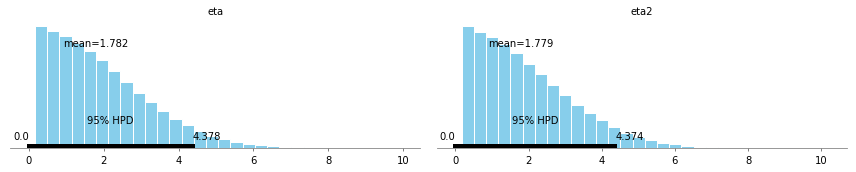

In [10]:
pm.plot_posterior(trace999, varnames=['eta', 'eta2']);

In [ ]:
pm.traceplot(trace99);

In [ ]:
with pm.Model() as model:
    eta = pm.HalfNormal("eta",tau=1/5)
    eta2 = pm.HalfNormal("eta2",tau=1)
    trace0 = pm.sample(2000, tuning = 800, progressbar=True, chains = 4, cores = 8)

In [ ]:
pm.plot_posterior(trace0, varnames=['eta', 'eta2']);

In [ ]:
df = pd.DataFrame([trace['step_size'].mean(),trace2['step_size'].mean()], columns=['Step_size'])
df['Divergent'] = pd.Series([trace99['diverging'].sum(),trace2['diverging'].sum()])
df['delta_target'] = pd.Series(['.99', '.80'])
df

In [79]:
df = pd.DataFrame([trace9['step_size'].mean(),trace99['step_size'].mean()], columns=['Step_size'])
df['Divergent'] = pd.Series([trace9['diverging'].sum(),trace99['diverging'].sum()])
df['delta_target'] = pd.Series(['.9', '.99'])
df

,Step_size,Divergent,delta_target
0,0.652486,21,.9
1,0.623823,17,.99
